In [ ]:
# Note :This notebook is run in Google colab with GPU settings added

In [1]:
from platform import python_version
python_version()

'3.8.8'

# ***TEXT BASED EMOTION CLASSIFICATION USING BERT FINE-TUNING APPROACHES***

**Install and load all dependencies**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow_text

In [ ]:
#Load all the required libraries
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM,Dense,Dropout
#add callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping , CSVLogger
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
from sklearn import metrics

In [ ]:
#Read data from drive

#df = pd.read_csv(r"C:\Users\William\Desktop\jo\nci\sem2\dmml2\project_emotion\dataset\train.txt")
df_train = pd.read_csv(r"/content/drive/MyDrive/datasets/emotion_dataset/train.txt", delimiter=';', header=None, names=['sentence','label'])
df_test = pd.read_csv(r"/content/drive/MyDrive/datasets/emotion_dataset/test.txt", delimiter=';', header=None, names=['sentence','label'])

df_train.head(5)

,sentence,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


# Data Cleaning

In [ ]:
#Missing values in training set
df_train.isnull().sum()
#Missing values in test set
df_test.isnull().sum()

sentence    0
label       0
dtype: int64

In [ ]:
#Data cleaning 
#The bert model will handle uncased and cased letters . 
#There is not much data processing required with bert models. 
#Stopwords are kept to identify the context.Lemmetization and stemming also not required.

def clean(text):
     # Just keep letters and important punctuation
    text = re.sub(r"[^a-zA-Z.!?']", ' ', text)
    # Remove additional spaces
    text = re.sub(r"\s+", ' ', text)
    return text 


In [ ]:
t=clean("i hhh uuu   uuu&?.!")
t

'i hhh uuu uuu ?.!'

In [ ]:
df_test.head(5)

,sentence,label
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


# EDA and Data Preprocessing

In [ ]:
df_train['label'].value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: label, dtype: int64

In [ ]:
df_test['label'].value_counts()

joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: label, dtype: int64

In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df_train['label_enc'] = labelencoder.fit_transform(df_train['label'])
df_test['label_enc'] = labelencoder.fit_transform(df_test['label'])


In [ ]:
df_train.rename(columns={'label':'label_desc'},inplace=True)
df_train.rename(columns={'label_enc':'label'},inplace=True)
df_test.rename(columns={'label':'label_desc'},inplace=True)
df_test.rename(columns={'label_enc':'label'},inplace=True)



In [ ]:
df_train.head(5)

,sentence,label_desc,label
0,i didnt feel humiliated,sadness,4
1,i can go from feeling so hopeless to so damned...,sadness,4
2,im grabbing a minute to post i feel greedy wrong,anger,0
3,i am ever feeling nostalgic about the fireplac...,love,3
4,i am feeling grouchy,anger,0


In [ ]:
classes

,label,label_desc
2,0,anger
7,1,fear
8,2,joy
3,3,love
0,4,sadness
6,5,surprise


In [ ]:
classes=df_train[["label","label_desc"]].drop_duplicates().sort_values(by=['label'])

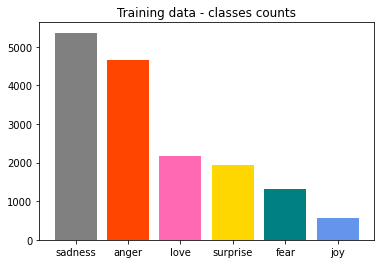

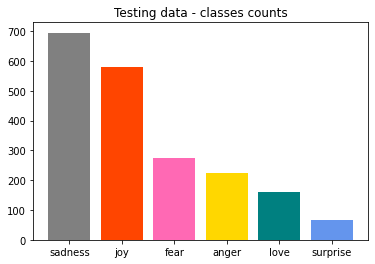

In [ ]:
# Visualize classes counts

colors = np.array(["gray", 'orangered', 'hotpink', 'gold', 'teal', 'cornflowerblue'])

plt.bar(df_train['label_desc'].unique(),height=df_train['label_desc'].value_counts(), color=colors)
plt.title("Training data - classes counts")
plt.show()

plt.bar(df_test['label_desc'].unique(),height=df_test['label_desc'].value_counts(), color=colors)
plt.title("Testing data - classes counts")
plt.show()



In [ ]:
df1=df_train[["sentence","label"]]
df2=df_test[["sentence","label"]]


In [ ]:
X_train=df1["sentence"].apply(clean)
Y_train=df1["label"]
#X_train=df1.sentence
type(X_train)
X_train = pd.DataFrame(data=X_train, columns=['sentence'])
Y_train = pd.DataFrame(data=Y_train, columns=['label'])

In [ ]:
X_test=df2["sentence"].apply(clean)
print(type(X_test))
Y_test=df2["label"]
#X_test=df_test.sentence
#type(X_test)


<class 'pandas.core.series.Series'>


In [ ]:
#over sampling the train data
sampling_strategy = {0: 5362, 1: 5362, 2: 5362,3:5362,4:5362,5:5362}
os=RandomOverSampler(sampling_strategy=sampling_strategy)

X_train_ns,Y_train_ns = os.fit_resample(X_train,Y_train)
print("The number of classes before {}".format(Counter(Y_train['label'])))
print("The number of classes after {}".format(Counter(Y_train_ns['label'])))

The number of classes before Counter({2: 5362, 4: 4666, 0: 2159, 1: 1937, 3: 1304, 5: 572})
The number of classes after Counter({4: 5362, 0: 5362, 3: 5362, 5: 5362, 1: 5362, 2: 5362})


In [ ]:
#Checking the counts after oversampling
Y_train_ns.value_counts()

label
0        5362
1        5362
2        5362
3        5362
4        5362
5        5362
dtype: int64

In [ ]:
classes


,label,label_desc,label_desc
2,0,anger,0
7,1,fear,1
8,2,joy,2
3,3,love,3
0,4,sadness,4
6,5,surprise,5


In [ ]:
Y_test.unique()

array([4, 2, 1, 0, 3, 5])

In [ ]:
#Converting the target variable to category
y_train1=tf.keras.utils.to_categorical(Y_train_ns)
y_test1=tf.keras.utils.to_categorical(Y_test)
y_train2=tf.keras.utils.to_categorical(Y_train)

# Load Pretrained Bert Encoder and Preprocessor

In [ ]:
#Load the bert encoder and associated preprocessor models from tensorhub
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1;")
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3;")

In [ ]:
#Checking the bert encoder output
preprocessed_text = bert_preprocess(["500$ discount. hurry up"])
embedded_text= bert_encoder(preprocessed_text)['pooled_output']
embedded_text


In [ ]:
#converting series to dataframe
X_train_ns=X_train_ns.squeeze()
type(y_train1)
len(X_train_ns)

32172

In [ ]:
y_test1

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:

#adam = Adam(learning_rate=0.005)

# Model Implementation

In [ ]:
#callbacks
checkpoint_filepath = '/content/drive/MyDrive/models/checkpoints/history_model_BertLSTM1.epoch{epoch:02d}-loss{val_loss:.2f}.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
Earlystopping=callback = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
)
log_csv=CSVLogger('/content/drive/MyDrive/models/checkpoints/my_logsmodel3.csv',separator=',',append=False)
callback_list=[Earlystopping,model_checkpoint_callback]

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

#model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5),
             # loss='categorical_crossentropy',
           # metrics=METRICS)

BERT BASE MODEL

In [ ]:
#Bert Model with single classification layer
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)
# Neural network layers
drop_out1 = tf.keras.layers.Dropout(0.2, name="dropout1")(outputs['pooled_output'])
l = tf.keras.layers.Dense(6, activation='softmax', name="output")(drop_out1)

# Use inputs and outputs to construct a final model
model_bert1 = tf.keras.Model(inputs=[text_input], outputs = [l])



In [ ]:
#model_bert1.layers[1]._name = 'Bert Preprocessor_layer'

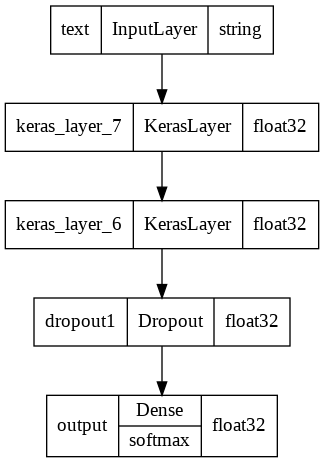

In [ ]:
dot_img_file = '/content/drive/MyDrive/datasets/images/model_bert1.png'
tf.keras.utils.plot_model(model_bert1, to_file=dot_img_file,  show_shapes=False,
  show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True)

In [ ]:
  model_bert1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=METRICS)

In [ ]:
history_model_bert1=model_bert1.fit(X_train_ns,y_train1, epochs=20,validation_data=(X_test,y_test1),callbacks=callback_list)

Epoch 1/20
1006/1006 [==============================] - 107s 105ms/step - loss: 1.5800 - accuracy: 0.8302 - precision: 0.4454 - recall: 0.0762 - val_loss: 1.5050 - val_accuracy: 0.8319 - val_precision: 0.4712 - val_recall: 0.0695
Epoch 2/20
1006/1006 [==============================] - 105s 104ms/step - loss: 1.4361 - accuracy: 0.8435 - precision: 0.6114 - recall: 0.1667 - val_loss: 1.4095 - val_accuracy: 0.8407 - val_precision: 0.6005 - val_recall: 0.1330
Epoch 3/20
1006/1006 [==============================] - 105s 104ms/step - loss: 1.4033 - accuracy: 0.8465 - precision: 0.6259 - recall: 0.1956 - val_loss: 1.3748 - val_accuracy: 0.8425 - val_precision: 0.6096 - val_recall: 0.1530
Epoch 4/20
1006/1006 [==============================] - 105s 105ms/step - loss: 1.3873 - accuracy: 0.8475 - precision: 0.6267 - recall: 0.2099 - val_loss: 1.4463 - val_accuracy: 0.8362 - val_precision: 0.5330 - val_recall: 0.1415
Epoch 5/20
1006/1006 [==============================] - 105s 105ms/step - loss: 

In [ ]:
history_modelbert1=model_bert1.fit(X_train_ns,y_train1, epochs=8,validation_data=(X_test,y_test1),callbacks=callback_list)

Epoch 1/8
1006/1006 [==============================] - 110s 110ms/step - loss: 1.3730 - accuracy: 0.8483 - precision: 0.6196 - recall: 0.2321 - val_loss: 1.3916 - val_accuracy: 0.8423 - val_precision: 0.5951 - val_recall: 0.1690
Epoch 2/8
1006/1006 [==============================] - 105s 105ms/step - loss: 1.3653 - accuracy: 0.8497 - precision: 0.6300 - recall: 0.2373 - val_loss: 1.4149 - val_accuracy: 0.8408 - val_precision: 0.5748 - val_recall: 0.1710
Epoch 3/8
1006/1006 [==============================] - 105s 104ms/step - loss: 1.3692 - accuracy: 0.8489 - precision: 0.6233 - recall: 0.2362 - val_loss: 1.3965 - val_accuracy: 0.8403 - val_precision: 0.5709 - val_recall: 0.1670
Epoch 4/8
1006/1006 [==============================] - 106s 105ms/step - loss: 1.3704 - accuracy: 0.8492 - precision: 0.6216 - recall: 0.2427 - val_loss: 1.3235 - val_accuracy: 0.8462 - val_precision: 0.6314 - val_recall: 0.1850
Epoch 5/8
1006/1006 [==============================] - 105s 105ms/step - loss: 1.373

In [ ]:
model_bert1.save("/content/drive/MyDrive/models/model_bert1.830")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/model_bert1.830/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/model_bert1.830/assets


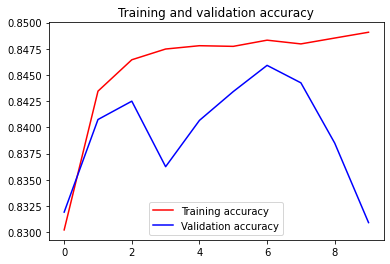

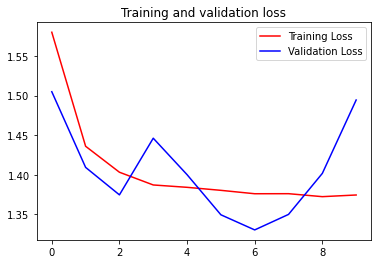

In [ ]:
# Visualize Loss & Accuracy

%matplotlib inline
import matplotlib.pyplot as plt
acc = history_model_bert1.history['accuracy']
val_acc = history_model_bert1.history['val_accuracy']
loss = history_model_bert1.history['loss']
val_loss = history_model_bert1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model_bert1.evaluate(X_test, y_test1)

63/63 [==============================] - 7s 114ms/step - loss: 1.4866 - accuracy: 0.8310 - precision: 0.4764 - recall: 0.1415


[1.486581802368164,
 0.8310002684593201,
 0.4764309823513031,
 0.14149999618530273]

# Bert-LSTM model

In [ ]:

# Bert layers
#model_BertLSTM1
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)
bert_out = tf.keras.layers.SpatialDropout1D(0.2)(outputs['sequence_output'])
l_lstm = LSTM(256)(bert_out)
newout = tf.keras.layers.Dense(768,activation='relu')(l_lstm)
preds = tf.keras.layers.Dense(units=6, activation='softmax')(newout)
model_BertLSTM1 = tf.keras.Model(inputs=[text_input], outputs = [preds])

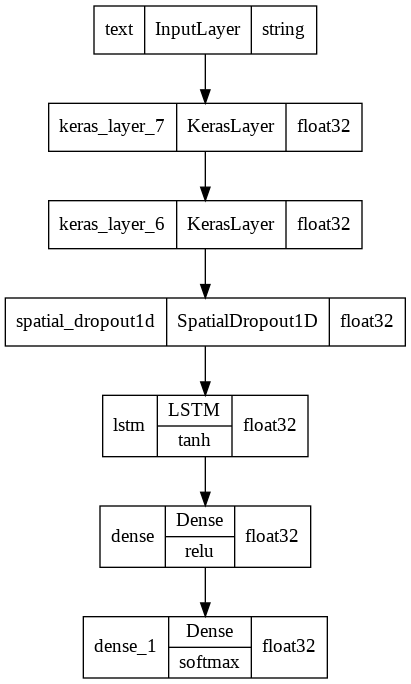

In [ ]:
dot_img_file = '/content/drive/MyDrive/datasets/images/model_BertLSTM1.png'
tf.keras.utils.plot_model(model_BertLSTM1, to_file=dot_img_file,  show_shapes=False,
  show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True)

In [ ]:
  model_BertLSTM1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=METRICS)

In [ ]:
history_model_BertLSTM1=model_BertLSTM1.fit(X_train_ns,y_train1, epochs=20,validation_data=(X_test,y_test1),callbacks=callback_list)

Epoch 1/20
1006/1006 [==============================] - 118s 117ms/step - loss: 0.3696 - accuracy: 0.9562 - precision: 0.8875 - recall: 0.8439 - val_loss: 0.5456 - val_accuracy: 0.9365 - val_precision: 0.8272 - val_recall: 0.7825
Epoch 2/20
1006/1006 [==============================] - 117s 117ms/step - loss: 0.2663 - accuracy: 0.9687 - precision: 0.9166 - recall: 0.8934 - val_loss: 0.5000 - val_accuracy: 0.9457 - val_precision: 0.8514 - val_recall: 0.8165
Epoch 3/20
1006/1006 [==============================] - 117s 116ms/step - loss: 0.2047 - accuracy: 0.9762 - precision: 0.9354 - recall: 0.9209 - val_loss: 0.5113 - val_accuracy: 0.9432 - val_precision: 0.8386 - val_recall: 0.8160
Epoch 4/20
1006/1006 [==============================] - 117s 116ms/step - loss: 0.1694 - accuracy: 0.9803 - precision: 0.9462 - recall: 0.9349 - val_loss: 0.4861 - val_accuracy: 0.9470 - val_precision: 0.8458 - val_recall: 0.8340
Epoch 5/20
1006/1006 [==============================] - 117s 116ms/step - loss: 

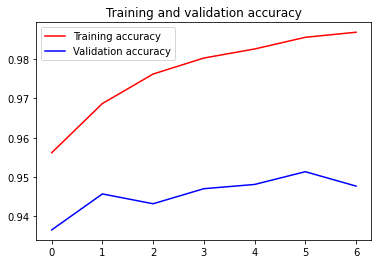

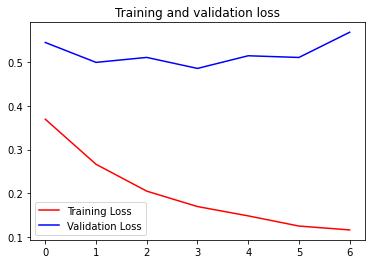

In [ ]:
# Visualize Loss & Accuracy

%matplotlib inline
import matplotlib.pyplot as plt
acc = history_model_BertLSTM1.history['accuracy']
val_acc = history_model_BertLSTM1.history['val_accuracy']
loss = history_model_BertLSTM1.history['loss']
val_loss = history_model_BertLSTM1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model_BertLSTM1.evaluate(X_test, y_test1)

63/63 [==============================] - 7s 112ms/step - loss: 0.4861 - accuracy: 0.9470 - precision: 0.8458 - recall: 0.8340


[0.48609718680381775,
 0.946999728679657,
 0.8458417654037476,
 0.8339999914169312]

In [ ]:
model_BertLSTM1.save("/content/drive/MyDrive/models/model_BertLSTM1.9470")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/model_BertLSTM1.9470/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/model_BertLSTM1.9470/assets


In [ ]:
#inputs = model.inputs[:2]
# Bert layers
#Bert+LSTM ---sigmoid activation
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)
bert_out = tf.keras.layers.SpatialDropout1D(0.2)(outputs['sequence_output'])
l_lstm = LSTM(256)(bert_out)
newout = tf.keras.layers.Dense(768,activation='relu')(l_lstm)
preds = tf.keras.layers.Dense(units=6, activation='sigmoid')(newout)
model_bertlstm2 = tf.keras.Model(inputs=[text_input], outputs = [preds])

In [ ]:
model_bertlstm2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=METRICS)

In [ ]:
history_model_bertlstm2=model_bertlstm2.fit(X_train_ns,y_train1, epochs=10,validation_data=(X_test,y_test1),callbacks=callback_list)

Epoch 1/10
1006/1006 [==============================] - 129s 121ms/step - loss: 1.2075 - accuracy: 0.6786 - precision: 0.3206 - recall: 0.8294 - val_loss: 0.8531 - val_accuracy: 0.7195 - val_precision: 0.3673 - val_recall: 0.9450
Epoch 2/10
1006/1006 [==============================] - 120s 119ms/step - loss: 0.5790 - accuracy: 0.7665 - precision: 0.4140 - recall: 0.9644 - val_loss: 0.6255 - val_accuracy: 0.7768 - val_precision: 0.4253 - val_recall: 0.9645
Epoch 3/10
1006/1006 [==============================] - 119s 118ms/step - loss: 0.3436 - accuracy: 0.8023 - precision: 0.4570 - recall: 0.9873 - val_loss: 0.5095 - val_accuracy: 0.7922 - val_precision: 0.4440 - val_recall: 0.9765
Epoch 4/10
1006/1006 [==============================] - 120s 119ms/step - loss: 0.2374 - accuracy: 0.8215 - precision: 0.4827 - recall: 0.9926 - val_loss: 0.4877 - val_accuracy: 0.8173 - val_precision: 0.4766 - val_recall: 0.9760
Epoch 5/10
1006/1006 [==============================] - 119s 119ms/step - loss: 

In [ ]:
model_bertlstm2.evaluate(X_test, y_test1)

63/63 [==============================] - 7s 107ms/step - loss: 0.4718 - accuracy: 0.8479 - precision: 0.5236 - recall: 0.9725


[0.47180405259132385,
 0.8479166030883789,
 0.523553192615509,
 0.9725000262260437]

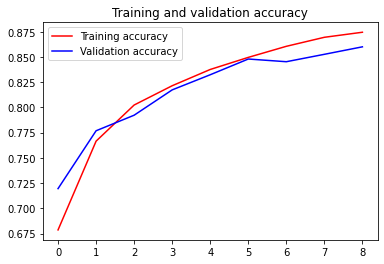

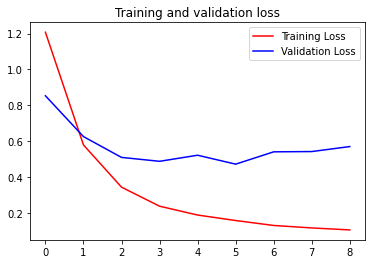

In [ ]:
# Visualize Loss & Accuracy

%matplotlib inline
import matplotlib.pyplot as plt
acc = history_model_bertlstm2.history['accuracy']
val_acc = history_model_bertlstm2.history['val_accuracy']
loss = history_model_bertlstm2.history['loss']
val_loss = history_model_bertlstm2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
#Bert + Lstm 
# 64 neurons in hidden layer
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)
bert_out = tf.keras.layers.SpatialDropout1D(0.2)(outputs['sequence_output'])
l_lstm = LSTM(256)(bert_out)
newout = tf.keras.layers.Dense(64,activation='relu')(l_lstm)
preds = tf.keras.layers.Dense(units=6, activation='softmax')(newout)
model_bert_lstm3 = tf.keras.Model(inputs=[text_input], outputs = [preds])

In [ ]:
model_bert_lstm3.compile(optimizer='adam',loss='categorical_crossentropy',metrics=METRICS)

In [ ]:
history_model_bert_lstm3=model_bert_lstm3.fit(X_train_ns,y_train1, epochs=30,validation_data=(X_test,y_test1),callbacks=callback_list)

Epoch 1/30
1006/1006 [==============================] - 165s 148ms/step - loss: 1.2210 - accuracy: 0.8636 - precision: 0.7145 - recall: 0.3029 - val_loss: 0.9302 - val_accuracy: 0.8843 - val_precision: 0.7235 - val_recall: 0.4945
Epoch 2/30
1006/1006 [==============================] - 145s 144ms/step - loss: 0.7389 - accuracy: 0.9143 - precision: 0.7933 - recall: 0.6568 - val_loss: 0.8687 - val_accuracy: 0.8957 - val_precision: 0.7322 - val_recall: 0.5905
Epoch 3/30
1006/1006 [==============================] - 145s 144ms/step - loss: 0.6059 - accuracy: 0.9298 - precision: 0.8267 - recall: 0.7325 - val_loss: 0.7194 - val_accuracy: 0.9134 - val_precision: 0.7713 - val_recall: 0.6830
Epoch 4/30
1006/1006 [==============================] - 145s 144ms/step - loss: 0.5293 - accuracy: 0.9387 - precision: 0.8458 - recall: 0.7731 - val_loss: 0.6974 - val_accuracy: 0.9155 - val_precision: 0.7742 - val_recall: 0.6960
Epoch 5/30
1006/1006 [==============================] - 145s 144ms/step - loss: 

In [ ]:
model_bert_lstm3.evaluate(X_test, y_test1)

63/63 [==============================] - 8s 124ms/step - loss: 0.6237 - accuracy: 0.9292 - precision: 0.8101 - recall: 0.7510


[0.6237002015113831,
 0.9291666746139526,
 0.8101402521133423,
 0.7509999871253967]

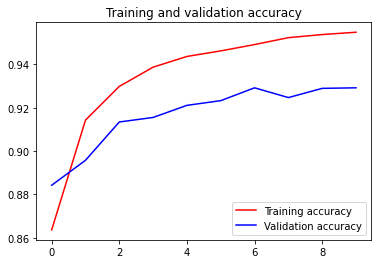

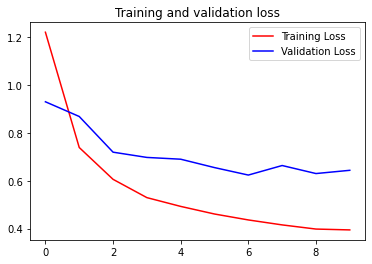

In [ ]:
# Visualize Loss & Accuracy

%matplotlib inline
import matplotlib.pyplot as plt
acc = model_bert_lstm3.history['accuracy']
val_acc = model_bert_lstm3.history['val_accuracy']
loss = model_bert_lstm3.history['loss']
val_loss = model_bert_lstm3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# BERT-BILSTM

In [ ]:
#BERT + Bi-LSTM
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
#LSTM_layer=LSTM(64,input_shape=(),return_sequences=True)
drop_out = tf.keras.layers.Dropout(0.6, name="dropout")(outputs['sequence_output'])
LSTM_layer1 = tf.keras.layers.Bidirectional(LSTM(80,name="LSTM_layer1",return_sequences=True))(drop_out)
drop_out_1 = tf.keras.layers.Dropout(0.6, name="dropout1")(LSTM_layer1)
layer_2 = Bidirectional(LSTM(40,name="LSTM_layer2"))(drop_out_1)
l = tf.keras.layers.Dense(6, activation='softmax', name="output")(layer_2)

# Use inputs and outputs to construct a final model
model_bert_bilstm = tf.keras.Model(inputs=[text_input], outputs = [l])



In [ ]:
model_bert_bilstm.compile(optimizer='adam',loss='categorical_crossentropy',metrics=METRICS)

In [ ]:
history_model_bert_bilstm=model_bert_bilstm.fit(X_train_ns,y_train1, epochs=30,validation_data=(X_test,y_test1),callbacks=callback_list)

Epoch 1/30
1006/1006 [==============================] - 154s 153ms/step - loss: 0.5414 - accuracy: 0.9355 - precision: 0.8380 - recall: 0.7597 - val_loss: 0.7783 - val_accuracy: 0.9141 - val_precision: 0.7637 - val_recall: 0.7015
Epoch 2/30
1006/1006 [==============================] - 153s 152ms/step - loss: 0.4919 - accuracy: 0.9416 - precision: 0.8517 - recall: 0.7863 - val_loss: 0.7887 - val_accuracy: 0.9094 - val_precision: 0.7450 - val_recall: 0.6940
Epoch 3/30
1006/1006 [==============================] - 153s 152ms/step - loss: 0.4483 - accuracy: 0.9472 - precision: 0.8658 - recall: 0.8083 - val_loss: 0.7311 - val_accuracy: 0.9180 - val_precision: 0.7731 - val_recall: 0.7190
Epoch 4/30
1006/1006 [==============================] - 153s 153ms/step - loss: 0.4136 - accuracy: 0.9515 - precision: 0.8761 - recall: 0.8256 - val_loss: 0.7930 - val_accuracy: 0.9165 - val_precision: 0.7621 - val_recall: 0.7255
Epoch 5/30
1006/1006 [==============================] - 153s 152ms/step - loss: 

In [ ]:
model_bert_bilstm.evaluate(X_test, y_test1)

63/63 [==============================] - 8s 125ms/step - loss: 0.7311 - accuracy: 0.9180 - precision: 0.7731 - recall: 0.7190


[0.7310883402824402, 0.9179999828338623, 0.773118257522583, 0.718999981880188]

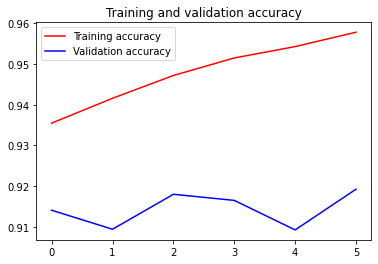

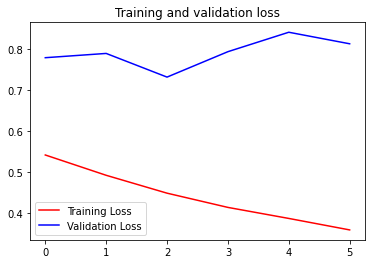

In [ ]:
# Visualize Loss & Accuracy

%matplotlib inline
import matplotlib.pyplot as plt
acc = history_model_bert_bilstm.history['accuracy']
val_acc = history_model_bert_bilstm.history['val_accuracy']
loss = history_model_bert_bilstm.history['loss']
val_loss = history_model_bert_bilstm.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [102]:
#Bert + 2 Bidirectional LSTM
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
#LSTM_layer=LSTM(64,input_shape=(),return_sequences=True)
drop_out = tf.keras.layers.Dropout(0.6, name="dropout")(outputs['sequence_output'])
LSTM_layer1 = Bidirectional(LSTM(80,name="LSTM_layer1",return_sequences=True))(drop_out)
drop_out1 = tf.keras.layers.Dropout(0.6, name="dropout1")(LSTM_layer1)
layer_2 = Bidirectional(LSTM(160,name="LSTM_layer2"))(drop_out1)
l = tf.keras.layers.Dense(6, activation='softmax', name="output")(layer_2)

# Use inputs and outputs to construct a final model
model_bert_bilstm2 = tf.keras.Model(inputs=[text_input], outputs = [l])

In [103]:
model_bert_bilstm2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=METRICS)

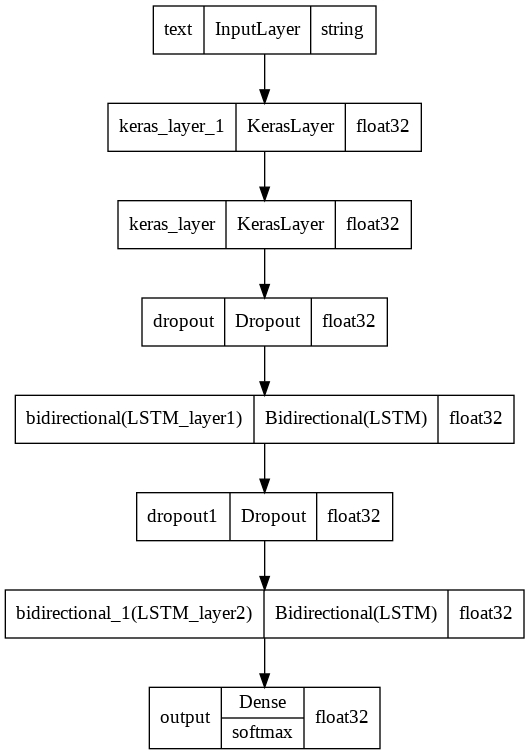

In [108]:
dot_img_file = '/content/drive/MyDrive/datasets/images/model_bert1.png'
tf.keras.utils.plot_model(model_bert_bilstm2, to_file=dot_img_file,  show_shapes=False,
  show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True)

In [104]:
history_model_bert_bilstm2=model_bert_bilstm2.fit(X_train_ns,y_train1, epochs=10,validation_data=(X_test, y_test1),callbacks=callback_list)

Epoch 1/10
1006/1006 [==============================] - 161s 147ms/step - loss: 1.2367 - accuracy: 0.8610 - precision: 0.6464 - recall: 0.3669 - val_loss: 1.1834 - val_accuracy: 0.8514 - val_precision: 0.5727 - val_recall: 0.4275
Epoch 2/10
1006/1006 [==============================] - 153s 152ms/step - loss: 0.8920 - accuracy: 0.8967 - precision: 0.7500 - recall: 0.5700 - val_loss: 1.0468 - val_accuracy: 0.8727 - val_precision: 0.6409 - val_recall: 0.5380
Epoch 3/10
1006/1006 [==============================] - 140s 139ms/step - loss: 0.7315 - accuracy: 0.9132 - precision: 0.7865 - recall: 0.6575 - val_loss: 0.8520 - val_accuracy: 0.8969 - val_precision: 0.7189 - val_recall: 0.6265
Epoch 4/10
1006/1006 [==============================] - 137s 136ms/step - loss: 0.6187 - accuracy: 0.9273 - precision: 0.8197 - recall: 0.7229 - val_loss: 0.8147 - val_accuracy: 0.9035 - val_precision: 0.7331 - val_recall: 0.6620
Epoch 5/10
1006/1006 [==============================] - 137s 137ms/step - loss: 

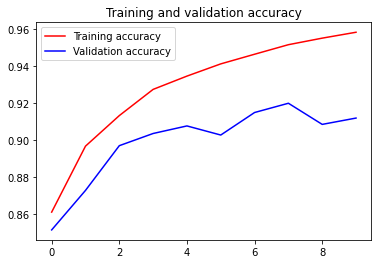

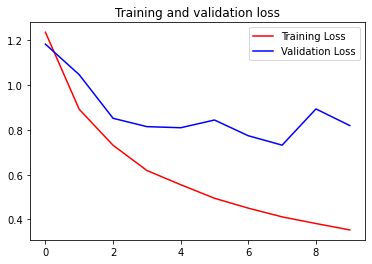

In [106]:
# Visualize Loss & Accuracy

%matplotlib inline
import matplotlib.pyplot as plt
acc = history_model_bert_bilstm2.history['accuracy']
val_acc = history_model_bert_bilstm2.history['val_accuracy']
loss = history_model_bert_bilstm2.history['loss']
val_loss = history_model_bert_bilstm2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [110]:
history_model_bert_bilstm2=model_bert_bilstm2.fit(X_train_ns,y_train1, epochs=8,validation_data=(X_test, y_test1),callbacks=callback_list)

Epoch 1/8
1006/1006 [==============================] - 146s 145ms/step - loss: 0.3400 - accuracy: 0.9603 - precision: 0.8970 - recall: 0.8604 - val_loss: 0.8773 - val_accuracy: 0.9168 - val_precision: 0.7601 - val_recall: 0.7320
Epoch 2/8
1006/1006 [==============================] - 137s 136ms/step - loss: 0.3138 - accuracy: 0.9630 - precision: 0.9026 - recall: 0.8721 - val_loss: 0.8555 - val_accuracy: 0.9146 - val_precision: 0.7535 - val_recall: 0.7245
Epoch 3/8
1006/1006 [==============================] - 136s 135ms/step - loss: 0.2977 - accuracy: 0.9651 - precision: 0.9080 - recall: 0.8796 - val_loss: 0.8505 - val_accuracy: 0.9175 - val_precision: 0.7619 - val_recall: 0.7345
Epoch 4/8
1006/1006 [==============================] - 136s 135ms/step - loss: 0.2807 - accuracy: 0.9674 - precision: 0.9141 - recall: 0.8880 - val_loss: 0.9160 - val_accuracy: 0.9144 - val_precision: 0.7512 - val_recall: 0.7275
Epoch 5/8
1006/1006 [==============================] - 136s 136ms/step - loss: 0.278

In [111]:
model_bert_bilstm2.evaluate(X_test, y_test1)

63/63 [==============================] - 8s 117ms/step - loss: 0.8505 - accuracy: 0.9175 - precision: 0.7619 - recall: 0.7345


[0.8505356311798096, 0.9174999594688416, 0.761929452419281, 0.734499990940094]

In [109]:
model_bert_bilstm2.evaluate(X_test, y_test1)

63/63 [==============================] - 7s 113ms/step - loss: 0.8195 - accuracy: 0.9118 - precision: 0.7505 - recall: 0.7055


[0.8195232152938843,
 0.9118331074714661,
 0.7505319118499756,
 0.7055000066757202]

In [ ]:
#Bert + single Bidirectional LSTM with sigmoid activation
# Bert layers
#model_9
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)
bert_out = tf.keras.layers.SpatialDropout1D(0.2)(outputs['sequence_output'])
l_lstm = Bidirectional(LSTM(256))(bert_out)
newout = tf.keras.layers.Dense(768,activation='relu')(l_lstm)
preds = tf.keras.layers.Dense(units=6, activation='sigmoid')(newout)
model_bert_bilstm3 = tf.keras.Model(inputs=[text_input], outputs = [preds])

In [ ]:
model_bert_bilstm3.compile(optimizer='adam',loss='categorical_crossentropy',metrics=METRICS)

In [ ]:
history_model_bert_bilstm3=model_bert_bilstm3.fit(X_train_ns,y_train1, epochs=10,validation_data=(X_test,y_test1),callbacks=callback_list)

Epoch 1/10
1006/1006 [==============================] - 160s 159ms/step - loss: 0.3613 - accuracy: 0.7822 - precision: 0.4327 - recall: 0.9873 - val_loss: 4.8923 - val_accuracy: 0.6387 - val_precision: 0.2354 - val_recall: 0.5195
Epoch 2/10
1006/1006 [==============================] - 154s 153ms/step - loss: 0.2264 - accuracy: 0.8118 - precision: 0.4695 - recall: 0.9943 - val_loss: 5.9731 - val_accuracy: 0.6529 - val_precision: 0.2432 - val_recall: 0.5125
Epoch 3/10
1006/1006 [==============================] - 152s 151ms/step - loss: 0.1731 - accuracy: 0.8282 - precision: 0.4923 - recall: 0.9962 - val_loss: 6.1359 - val_accuracy: 0.6633 - val_precision: 0.2493 - val_recall: 0.5070
Epoch 4/10
1006/1006 [==============================] - 153s 152ms/step - loss: 0.1404 - accuracy: 0.8405 - precision: 0.5110 - recall: 0.9975 - val_loss: 6.5165 - val_accuracy: 0.6680 - val_precision: 0.2471 - val_recall: 0.4845


In [ ]:
#The validation loss is increasing in the output.so this case cannot be considered

# Result Analysis - Confusion matrix

In [ ]:
# From the analysis Bert + Lstm gives the best accuracy,precision,recall and least loss values. Hence we have chosen 
#this model as the final. In this section we will be evaluating the model performance on all classes.

**Load the Bert LSTM model with best results**

In [34]:
loaded_model=tf.keras.models.load_model("/content/drive/MyDrive/models/model_BertLSTM1.9470")

Test the model performance

In [36]:
loaded_model.evaluate(X_test, y_test1)

63/63 [==============================] - 13s 168ms/step - loss: 0.4861 - accuracy: 0.9470 - precision: 0.8458 - recall: 0.8340


[0.48609718680381775,
 0.946999728679657,
 0.8458417654037476,
 0.8339999914169312]

In [87]:
classes

,label,label_desc
2,0,anger
7,1,fear
8,2,joy
3,3,love
0,4,sadness
6,5,surprise


**Predict a single text**

In [88]:
input_test=["i am astonished hearing this"]
probs=loaded_model.predict(input_test)
probs[0]

array([1.7733749e-03, 1.7670012e-03, 3.9944970e-03, 2.5802967e-06,
       1.9804237e-03, 9.9048209e-01], dtype=float32)

In [89]:
k=np.argmax(probs[0])
if k == 0:
  print("Output of the model: {}\nPredicted sentiment: anger.".format(
            k))
elif k == 1:
  print("Output of the model: {}\nPredicted sentiment: fear.".format(k))
           
elif k == 2:
  print("Output of the model: {}\nPredicted sentiment: joy.".format(k))
           
elif k == 3:
  print("Output of the model: {}\nPredicted sentiment: love.".format(k))
           
elif k == 4:
  print("Output of the model: {}\nPredicted sentiment: sadness.".format(k))
         
elif k == 5: 
  print("Output of the model: {}\nPredicted sentiment: surprise.".format(k))

Output of the model: 5
Predicted sentiment: surprise.


**Plotting Confusion matrix on test data**

In [90]:
y_predicted = loaded_model.predict(X_test)
y_pred=[]

In [91]:
for i in y_predicted:
    y_pred.append(np.argmax(i))

In [92]:
y_pred1=pd.Series(y_pred)
y_pred1

0       4
1       4
2       4
3       2
4       4
       ..
1995    0
1996    0
1997    2
1998    2
1999    1
Length: 2000, dtype: int64

In [94]:
print(classification_report(Y_test,y_pred1))

              precision    recall  f1-score   support

           0       0.79      0.84      0.81       275
           1       0.79      0.85      0.82       224
           2       0.90      0.89      0.89       695
           3       0.67      0.74      0.70       159
           4       0.90      0.85      0.87       581
           5       0.65      0.52      0.58        66

    accuracy                           0.84      2000
   macro avg       0.78      0.78      0.78      2000
weighted avg       0.84      0.84      0.84      2000



In [96]:
from sklearn import metrics
cm=metrics.confusion_matrix(Y_test,y_pred1)

In [97]:
print(cm)

[[231  11   9   3  21   0]
 [  7 190   5   0   9  13]
 [  8   2 616  45  19   5]
 [  3   3  30 117   6   0]
 [ 42  17  20   9 493   0]
 [  3  19   8   0   2  34]]


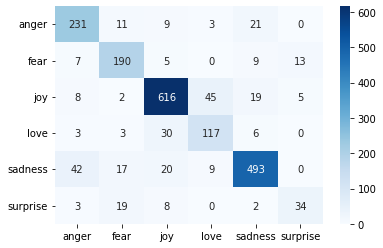

In [101]:
x_axis_labels = ["anger","fear","joy","love","sadness","surprise"] # labels for x-axis
y_axis_labels = ["anger","fear","joy","love","sadness","surprise"] # labels for y-axis

# create seabvorn heatmap with required labels
sns.heatmap(cm,annot =True,cmap='Blues', fmt='g', xticklabels=x_axis_labels, yticklabels=y_axis_labels)